In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

## Compare RMSE

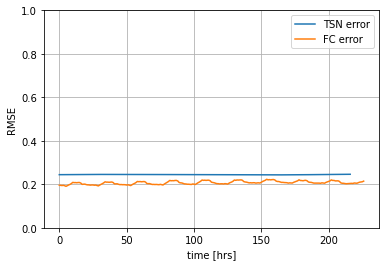

In [6]:
#synthetic
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
files = os.listdir(error_data_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_data_root, file), engine="netcdf4")
    rmse.append(rmse_over_time_xr(data, variables=("water_u", "water_v")))
rmse = np.array(rmse).mean(axis=0)

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(rmse)), rmse, label="TSN error")

# empirical
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data, variables=("u_error", "v_error"))["rmse"])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)

plt.plot(range(len(rmse_data)), rmse_data, label="FC error")
plt.ylim([0, 1.0])
# plt.title("Empirical RMSE vs Synthetic RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()
plt.legend()
plt.savefig("/home/jonas/Downloads/tsn_rmse.png", dpi=300, bbox_inches="tight")

## Compute Synthetic Vector Correlation

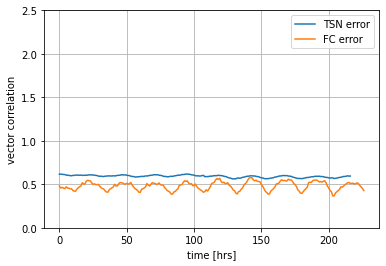

In [4]:
# synthetic
# forecast + synth error vs forecast
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
error_files = sorted(os.listdir(error_data_root))

forecast_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
forecast_files = sorted(os.listdir(forecast_root))[:len(error_files)]

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_data_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(vec_corr)), vec_corr, label="TSN error")

# empirical
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast
forecast_error_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1_edited"
error_files = sorted(os.listdir(forecast_error_root))[:20]
vec_corr = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    vec_corr.append(vector_correlation_over_time(data))
vec_corr = np.array(vec_corr).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr, label="FC error")
plt.ylim([0, 2.5])
# plt.title("Empirical Vector Correlation vs Synthetic Vector Correlation")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()
plt.legend()
plt.savefig("/home/jonas/Downloads/tsn_vec_corr.png", dpi=300, bbox_inches="tight")

## Sample from Simplex Noise Sample and compute Variogram

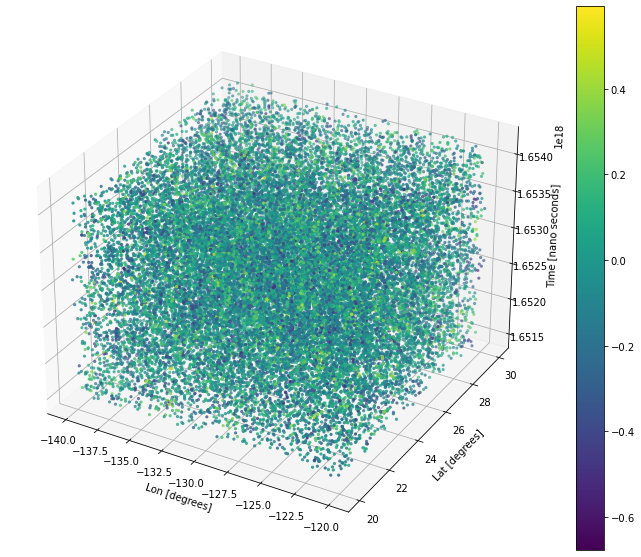

In [19]:
import os
import xarray as xr
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = xr.load_dataset("/home/jonas/Downloads/test_noise.nc")
# data = xr.load_dataset("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/sampled_noise.nc")
lon_len = len(data["lon"].values)
lat_len = len(data["lat"].values)
time_len = len(data["time"].values)
total_len = lon_len * lat_len * time_len

idx = np.random.choice(list(range(total_len)), size=30000)

lon = data["lon"].values.reshape(-1)
lat = data["lat"].values.reshape(-1)
time = data["time"].values.reshape(-1)

axes = np.array(list(itertools.product(time, lat, lon)))[idx]
time = axes[:, 0]
lat = axes[:, 1]
lon = axes[:, 2]
u_error = data["water_u"].values.reshape(-1)[idx]
v_error = data["water_v"].values.reshape(-1)[idx]

data = pd.DataFrame({"lon": lon,
                     "lat": lat,
                     "time": time,
                     "u_error": u_error,
                     "v_error": v_error})

time_plot = np.array(time, dtype=np.int64)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
plot = ax.scatter(lon, lat, time_plot, c=u_error, marker=".")
ax.set_xlabel("Lon [degrees]")
ax.set_ylabel("Lat [degrees]")
ax.set_zlabel("Time [nano seconds]")
plt.colorbar(plot, ax=ax)

In [21]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

print(data)
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)

              lon        lat                time   u_error   v_error
0     -134.916667  22.833333 2022-05-05 11:30:00  0.001919 -0.176675
1         -123.25  21.166667 2022-05-25 06:30:00  0.131318 -0.181624
2     -129.333333      29.75 2022-05-09 04:30:00 -0.271843 -0.177124
3     -126.416667       20.5 2022-05-29 16:30:00 -0.176875 -0.142399
4     -121.166667       29.0 2022-05-06 21:30:00  0.135672 -0.437542
...           ...        ...                 ...       ...       ...
29995 -125.083333       24.5 2022-05-16 20:30:00 -0.196970  0.181338
29996 -135.416667  29.916667 2022-05-31 10:30:00  0.192126 -0.167075
29997     -130.75  24.083333 2022-05-18 08:30:00  0.016995 -0.166273
29998 -135.583333  27.666667 2022-05-07 11:30:00  0.006548  0.040421
29999 -139.833333  22.166667 2022-05-23 23:30:00 -0.075297 -0.198079

[30000 rows x 5 columns]


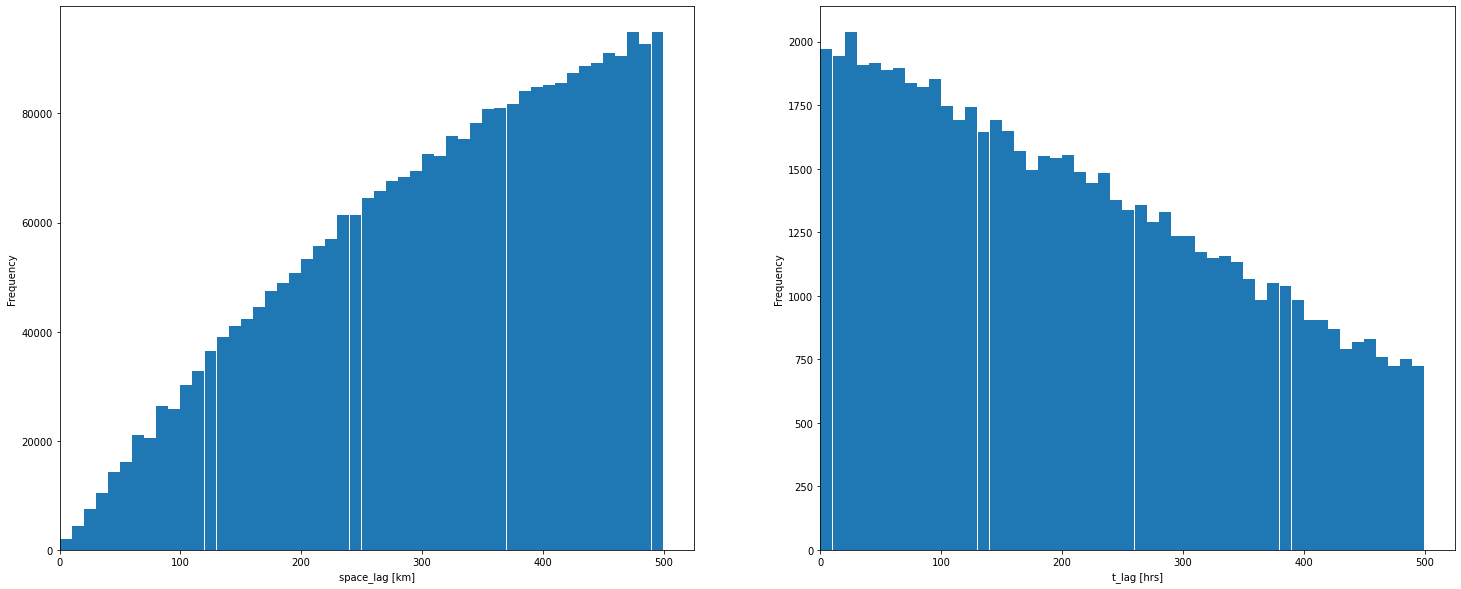

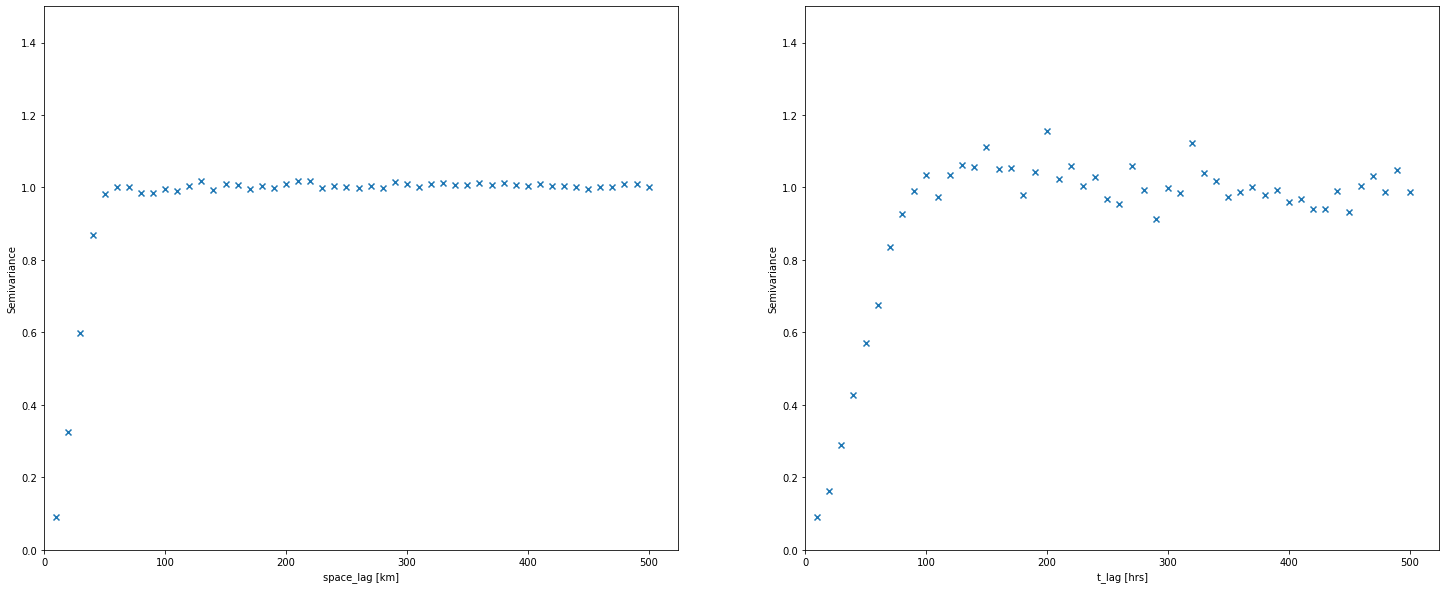

In [24]:
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [500, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(error_variable="u", view_range=view_range)

## Compute stats of opensimplex

In [34]:
import opensimplex
import numpy as np

simplex_gen = opensimplex.OpenSimplex(seed=12345678)
num_pts = int(2e2)
num_of_loops = 100
means = []
sum = 0
sumsq = 0
for i in range(num_of_loops):
    rand_x = np.random.uniform(0, 1000, num_pts)
    rand_y = np.random.uniform(0, 1000, num_pts)
    rand_z = np.random.uniform(0, 1000, num_pts)
    rand_t = np.random.uniform(0, 1000, num_pts)
    samples = np.array(simplex_gen.noise3array(rand_x, rand_y, rand_z))
    means.append(samples.mean())
    sum += samples.sum()
    sumsq += np.square(samples).sum()

print(np.array(means).mean())
print((sumsq - (sum * sum)/(num_of_loops*num_pts**3))/(num_of_loops*num_pts**3))

-7.076037679000259e-06
0.09792579099296904


# Final Simulation GT

In [2]:
from ocean_navigation_simulator.generative_error_model.models.OceanCurrentNoiseField import OceanCurrentNoiseField
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import itertools

# load HC
hc_path = "../../../data/drifter_data/hindcasts/area1"
file = sorted(os.listdir(hc_path))[0]
file_path = os.path.join(hc_path, file)
hc = xr.open_dataset(file_path)
hc = hc.sel(longitude=slice(-146.25, -125),
            latitude=slice(15, 36.25))

# get noise
noise_config_path = "../../../data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited2.npy"
print(np.load(noise_config_path, allow_pickle=True))
noise_model = OceanCurrentNoiseField.load_config_from_file(noise_config_path)
noise_model.reset(np.random.default_rng(130))
noise = noise_model.get_noise_from_axes(hc["longitude"].values, hc["latitude"].values, hc["time"].values)

# get magnitudes
hc_mag = np.sqrt(hc["utotal"].values.squeeze()**2 + hc["vtotal"].values.squeeze()**2)
noise_mag = np.sqrt(noise["water_u"].values **2 + noise["water_v"].values**2)

time_step = 0
# produce data
hc_mag = hc_mag[time_step]
noise_mag = noise_mag[time_step]
# combined_mag = hc_mag + noise_mag
combined_mag = np.sqrt((hc["utotal"].values.squeeze() + noise["water_u"].values)**2 + (hc["vtotal"].values.squeeze() + noise["water_v"].values)**2)[time_step]

{'U_COMP': [array([2.11485852e-01, 1.84531759e+02, 1.84531759e+02, 2.32639714e+02]), array([2.07652204e-01, 2.33082361e+02, 2.33082361e+02, 2.08976540e+01]), array([  0.24010884, 100.897654  , 100.897654  , 120.290657  ]), array([  0.3407531 , 231.79058997, 231.79058997, 100.897654  ])], 'V_COMP': [array([2.01706547e-01, 2.00897654e+02, 2.00897654e+02, 2.04855062e+02]), array([2.30915429e-01, 2.64812857e+02, 2.64812857e+02, 4.08076230e+01]), array([  0.23304021, 150.897654  , 150.897654  , 185.93637036]), array([ 0.33433782, 68.11396633, 68.11396633, 30.897654  ])], 'detrend_metrics': [[-0.0446293197270464, 0.17572066038165515], [-0.06611381479194962, 0.14546674762967093]]}


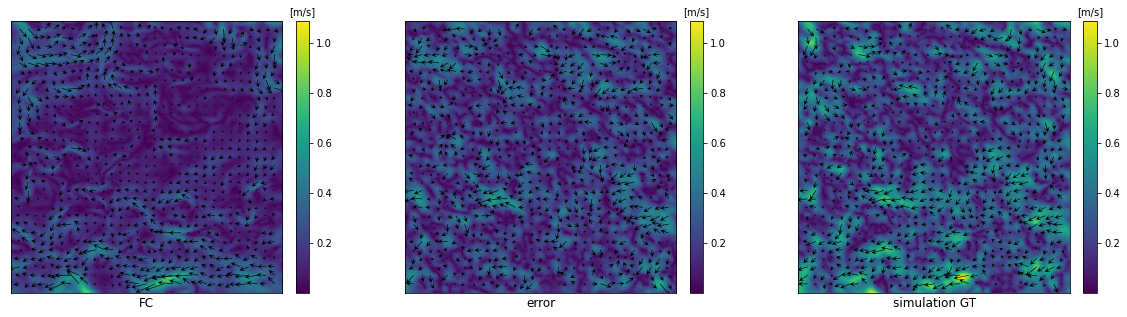

In [6]:
def get_quiver_values(u_cur=None, v_cur=None, arrow_spacing=8, time_step=0):
    quiver_coord_helper = np.arange(arrow_spacing, u_cur[time_step].squeeze().shape[0], arrow_spacing)
    coords = list(itertools.product(quiver_coord_helper, quiver_coord_helper))
    quiver_x = [pair[0] for pair in coords]
    quiver_y = [pair[1] for pair in coords]
    if u_cur[0] is not None:
        quiver_u = list(u_cur[time_step].squeeze()[quiver_y, quiver_x])
    else:
        quiver_u = np.zeros(len(quiver_x))
    if v_cur is not None:
        quiver_v = list(v_cur[time_step].squeeze()[quiver_y, quiver_x])
    else:
        quiver_v = np.zeros(len(quiver_x))
    return quiver_x, quiver_y, quiver_u, quiver_v

font_size = 12
quiver_settings = {"headwidth": 8, "headlength": 8, "color": "k"}
fig, axs = plt.subplots(1, 3, figsize=(20,5))
hc_frame = axs[0].imshow(hc_mag, origin="lower", vmin=np.min(combined_mag), vmax=np.max(combined_mag))
axs[0].quiver(*get_quiver_values(hc["utotal"].values, hc["vtotal"].values), angles="xy", **quiver_settings)
axs[0].set_xlabel("FC", fontdict={"size": font_size})
clb = plt.colorbar(hc_frame, ax=axs[0], fraction=0.046, pad=0.04)
clb.ax.set_title('[m/s]', fontdict={"size": 10})

noise_frame = axs[1].imshow(noise_mag, origin="lower", vmin=np.min(combined_mag), vmax=np.max(combined_mag))
axs[1].set_xlabel("error", fontdict={"size": font_size})
axs[1].quiver(*get_quiver_values(noise["water_u"].values, noise["water_v"].values), angles="xy", **quiver_settings)
clb = plt.colorbar(noise_frame, ax=axs[1], fraction=0.046, pad=0.04)
clb.ax.set_title('[m/s]', fontdict={"size": 10})

total_frame = axs[2].imshow(combined_mag, origin="lower", vmin=np.min(combined_mag), vmax=np.max(combined_mag))
axs[2].set_xlabel("simulation GT", fontdict={"size": font_size})
axs[2].quiver(*get_quiver_values(hc["utotal"].values.squeeze()+noise["water_u"].values.squeeze(),
                                 hc["vtotal"].values.squeeze()+noise["water_v"].values.squeeze()), angles="xy", **quiver_settings)
clb = plt.colorbar(total_frame, ax=axs[2], fraction=0.046, pad=0.04)
clb.ax.set_title('[m/s]', fontdict={"size": 10})

# Turn off tick labels
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.savefig("/home/jonas/Downloads/tsn_final_mag_quiver.png", bbox_inches="tight", dpi=300)
plt.show()

225 225


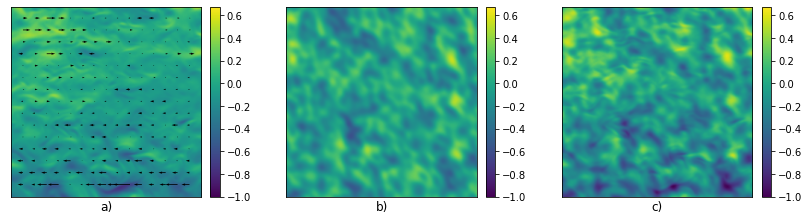

In [92]:
time_step = 0
# noise_mag = noise_mag*0.5

arrow_spacing = 16
quiver_coord_helper = np.arange(arrow_spacing, hc_mag.shape[0], arrow_spacing)
coords = list(itertools.product(quiver_coord_helper, quiver_coord_helper))
quiver_x = [pair[0] for pair in coords]
quiver_y = [pair[1] for pair in coords]
quiver_u = list(hc["utotal"].values[time_step].squeeze()[quiver_y, quiver_x])
quiver_v = np.zeros(len(quiver_u))
print(len(quiver_y), len(quiver_v))
font_size = 12

# produce data
hc_u = np.moveaxis(hc["utotal"].values[time_step], 0, -1).squeeze()
noise_u = np.moveaxis(noise["water_u"].values[time_step], 0, -1)
combined_u = hc_u + noise_u

# plot others
fig, axs = plt.subplots(1, 3, figsize=(14,3.5))
hc_frame = axs[0].imshow(hc_u, origin="lower", vmin=np.min(combined_u), vmax=np.max(combined_u))
axs[0].set_xlabel("a)", fontdict={"size": font_size})
axs[0].quiver(quiver_x, quiver_y, quiver_u, quiver_v, angles="xy", scale_units="xy", scale=0.03)
plt.colorbar(hc_frame, ax=axs[0], fraction=0.046, pad=0.04)
noise_frame = axs[1].imshow(noise_u, origin="lower", vmin=np.min(combined_u), vmax=np.max(combined_u))
axs[1].set_xlabel("b)", fontdict={"size": font_size})
plt.colorbar(noise_frame, ax=axs[1], fraction=0.046, pad=0.04)
total_frame = axs[2].imshow(combined_u, origin="lower")
axs[2].set_xlabel("c)", fontdict={"size": font_size})
plt.colorbar(total_frame, ax=axs[2], fraction=0.046, pad=0.04)


# Turn off tick labels
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

0.068359375
49 49


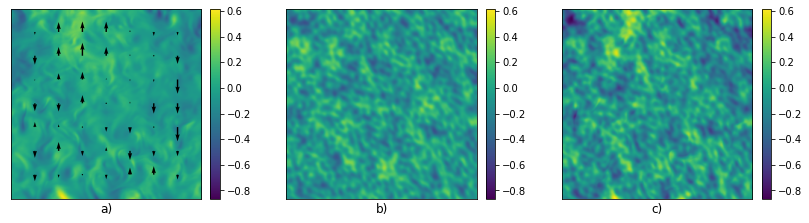

In [85]:
time_step = 0
# noise_mag = noise_mag*0.5

arrow_spacing = 32
quiver_coord_helper = np.arange(arrow_spacing, hc_mag.shape[0], arrow_spacing)
coords = list(itertools.product(quiver_coord_helper, quiver_coord_helper))
quiver_x = [pair[0] for pair in coords]
quiver_y = [pair[1] for pair in coords]
quiver_v = np.array(hc["vtotal"].values[time_step].squeeze()[quiver_y, quiver_x])
print(quiver_v[2])
quiver_u = np.zeros(quiver_v.shape)
print(len(quiver_y), len(quiver_v))
font_size = 12

# produce data
hc_u = np.moveaxis(hc["vtotal"].values[time_step], 0, -1).squeeze()
noise_u = np.moveaxis(noise["water_v"].values[time_step], 0, -1)
combined_u = hc_u + noise_u

# plot others
fig, axs = plt.subplots(1, 3, figsize=(14,3.5))
hc_frame = axs[0].imshow(hc_u, origin="lower", vmin=np.min(combined_u), vmax=np.max(combined_u))
axs[0].set_xlabel("a)", fontdict={"size": font_size})
axs[0].quiver(quiver_x, quiver_y, quiver_u, quiver_v, angles="xy", scale_units="xy", scale=0.01)
plt.colorbar(hc_frame, ax=axs[0], fraction=0.046, pad=0.04)
noise_frame = axs[1].imshow(noise_u, origin="lower", vmin=np.min(combined_u), vmax=np.max(combined_u))
axs[1].set_xlabel("b)", fontdict={"size": font_size})
plt.colorbar(noise_frame, ax=axs[1], fraction=0.046, pad=0.04)
total_frame = axs[2].imshow(combined_u, origin="lower")
axs[2].set_xlabel("c)", fontdict={"size": font_size})
plt.colorbar(total_frame, ax=axs[2], fraction=0.046, pad=0.04)


# Turn off tick labels
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

# Diversity Analysis

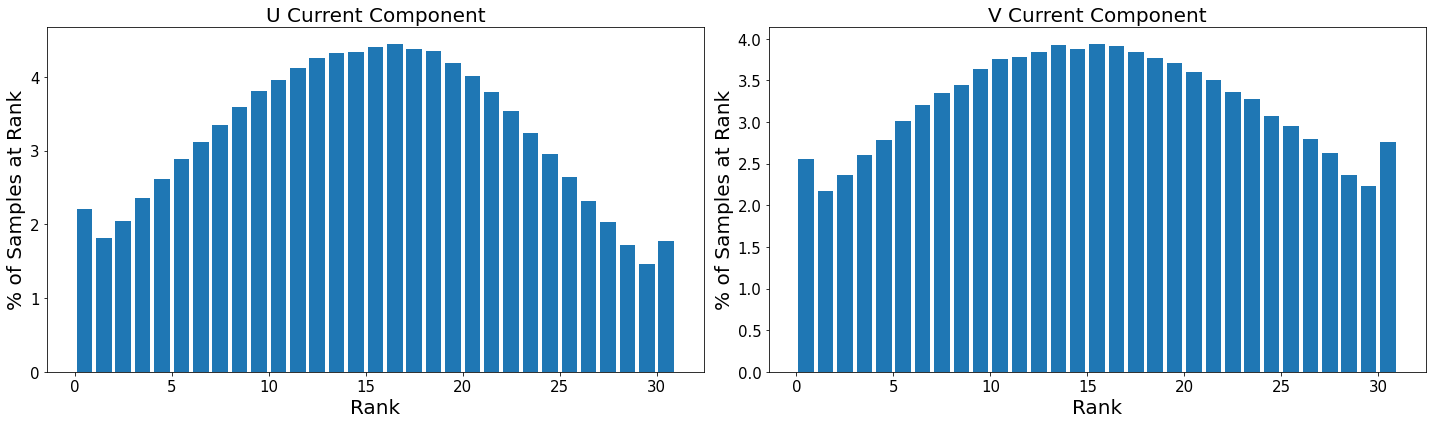

In [15]:
from ocean_navigation_simulator.generative_error_model.models.OceanCurrentNoiseField import OceanCurrentNoiseField
import matplotlib.pyplot as plt
import ensverif as e
import pandas as pd
import numpy as np
import datetime
import os

# load Fc errors
data_dir = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(data_dir))
df = pd.DataFrame()
for file in files:
    df = pd.concat([df, pd.read_csv(os.path.join(data_dir, file))], ignore_index=True)
error = df.dropna()

# get noise
noise_config = "../../../data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited2.npy"
noise_source = OceanCurrentNoiseField.load_config_from_file(noise_config)
rng = np.random.default_rng(42)

# a day long error
lon_interval = [-140, -120]
lat_interval = [20, 30]
time_interval = [datetime.datetime(2022, 5, 1), datetime.datetime(2022, 5, 2)]

rank_histograms = []
for current_comp in ["u", "v"]:
    errors = error[f"{current_comp}_error"]
    num_ensembles = 30
    obs = None
    size_day = (20*12+1)*(10*12+1)*25
    ensemble = np.zeros((len(errors), num_ensembles))
    for i in range(num_ensembles):
        noise_source.reset(rng)
        noise = noise_source.get_noise_from_ranges(lon_interval, lat_interval, time_interval)
        ensemble[:, i] = noise[f"water_{current_comp}"].values.flatten()[np.random.choice(size_day, len(errors))]

    rel_freq, bins = e.rankhist(ensemble, errors)
    rank_histograms.append([rel_freq, bins])

name_dict = {0: "U", 1: "V"}
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for i, ax in enumerate(axs):
    bins = rank_histograms[i][1]
    rel_freq = rank_histograms[i][0]
    ax.bar(bins[1:len(bins)], rel_freq*100)
    ax.set_ylabel("% of Samples at Rank", fontdict={"size":20})
    ax.set_xlabel("Rank", fontdict={"size":20})
    ax.set_title(f"{name_dict[i]} Current Component", size=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig("/home/jonas/Downloads/tsn_rank_histogram.png", dpi=300, bbox_inches="tight")